# Notes
* Is my method of testing it on iterations of new train test splits canonical or bad? 
* Is it possible to do gradient descent with an algorithm such as Levenberg-Marquart in $n$-dimensions? If so could that be applied to hyperparameter tuning, where $z(x_1, x_2,...x_n)$ is the mean loss function being optimized based on $x$ hyperparameter arrays? 
* Is there such a thing as multi-output linear regression? 
* How correlated are QPO properties with eachother? I should look into this. 
* I think I need to re do this testing scheme because re-splitting on each test could confound the results.
* Paper which seems to do similiar testing scheme: `https://arxiv.org/pdf/1903.07167.pdf` 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale as normalize
from sklearn.metrics import confusion_matrix, accuracy_score

np.set_printoptions(suppress=True)
pd.set_option("display.max_columns", None, "display.max_rows", None)

plt.style.use('seaborn-darkgrid')
plt.rcParams['font.family']='serif'

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
with open('/content/gdrive/My Drive/Colab Outputs/Hyperparameter Tuning/file.txt', 'w') as f:
  f.write('content')

In [ ]:
df = pd.read_csv('https://github.com/thissop/MAXI-J1535/raw/main/data/processed/fixed_merged.csv')
df = df.sample(frac=1)

In [ ]:
# pairplot 
pair_df = df[['hardness','tins','disk_norm','gammas','nthcomp_norms','fit_stats','red_fit_stats','count_rates','bg_ratio','intensities','num_qpos', 'red_fit_stats']]
print(pair_df)
#sns.pairplot(data=pair_df) # Not working fix this

In [ ]:
# Correlation matrix plot
corr_df = df[['hardness','tins','disk_norm','gammas','nthcomp_norms','fit_stats','red_fit_stats','count_rates','bg_ratio','intensities','num_qpos']].corr()

sns.heatmap(corr_df, cmap='Blues')

plt.title('Correlation Matrix\nMost Correlated: disk_norm ('+r'$r^2=$'+'0.89)')

print(corr_df)

In [ ]:
# X

arr_names =  ['hardness', 'tins', 'disk_norm', 'gammas', 'nthcomp_norms', 'intensities']
(hardness, tins, disk_norms, gammas, nthcomp_norms, intensities) = (normalize(np.array(df[arr_name])) for arr_name in arr_names)

# Y
num_qpos = np.array(df['num_qpos']).reshape(len(df), 1)
## Stack x values
x_vals = np.array([], dtype=np.int64).reshape(0,6)

for a, b, c, d, e, f in zip(hardness, tins, disk_norms, gammas, nthcomp_norms, intensities): 
    new_arr = np.array([float(a), float(b), float(c), float(d), float(e), float(f)])
    x_vals = np.vstack([x_vals, new_arr])

def split_data(): 
    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(x_vals, num_qpos, test_size=0.1)
    return X_train, X_test, y_train, y_test

In [ ]:
def knn_predict(k, xtrain, ytrain, xtest, ytest): 
    knn = KNeighborsClassifier(k)
    knn.fit(xtrain, ytrain)
    predictions = knn.predict(xtest)
    acc = accuracy_score(predictions, ytest.flatten())

    return acc, predictions

In [ ]:
ks = np.arange(1, 31, 1)
accs = np.array([])

for k in ks: 
    X_train, X_test, y_train, y_test = split_data()
    acc = knn_predict(k, X_train, np.ravel(y_train), X_test, y_test)[0]
    accs = np.append(accs, acc)

In [ ]:
# k vs acc plot
plt.scatter(ks, accs)
plt.xlabel('k')
plt.ylabel('acc')
plt.title('K vs Accuracy\nMost Accurate: k=1-3; acc=0.84')

In [ ]:
# k=3 confusion matrix
y_test = y_test.flatten()

acc, predictions = knn_predict(7, X_train, y_train, X_test, y_test)

predictions = predictions.flatten()

fig, ax = plt.subplots(figsize=(10, 8))
plt.rcParams['font.family']='serif'

cm = confusion_matrix(y_test.flatten(), predictions)

sns.heatmap(cm, annot=True, cmap='Blues', linewidths=.5)
plt.xlabel('Actual')
plt.ylabel('Predicted')

plt.title('Confusion Matrix\nAccuracy: '+str(round(acc, 3)))
plt.show()

## K tuning

In [ ]:
ks = np.arange(1, 9, 1)
accs = np.array([], dtype=np.float32).reshape(0, 100)

for k_idx, k in enumerate(ks): 
    current_accs = np.array([])
    for i in range(100): 
        X_train, X_test, y_train, y_test = split_data()
        acc = knn_predict(k, X_train, np.ravel(y_train), X_test, y_test)[0]
        current_accs = np.append(current_accs, acc)

    accs = np.vstack((accs, current_accs))

In [ ]:
for k, acc_row in zip(ks, accs): 
    print(k, np.mean(acc_row), np.std(acc_row))

## Parameter Searching

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import keras
from keras import models, layers
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, median_absolute_error
from scipy.stats import linregress
from google.colab import files

np.set_printoptions(suppress=True)

In [4]:
combined_df = pd.read_csv('https://raw.githubusercontent.com/thissop/MAXI-J1535/main/data/processed/fixed_merged.csv')

combined_df = combined_df.sample(frac=1) # shuffle the dataframe

def normalize(x):
    x = (x-min(x))/(max(x)-min(x))
    return x

# X

arr_names =  ['hardness', 'tins', 'disk_norm', 'gammas', 'nthcomp_norms', 'intensities']
(hardness, tins, disk_norms, gammas, nthcomp_norms, intensities) = (normalize(np.array(combined_df[arr_name])) for arr_name in arr_names)

## Stack x values
x_vals = np.array([], dtype=np.int64).reshape(0,6) # why are they type int

for a, b, c, d, e, f in zip(hardness, tins, disk_norms, gammas, nthcomp_norms, intensities): 
    new_arr = np.array([float(a), float(b), float(c), float(d), float(e), float(f)])
    x_vals = np.vstack([x_vals, new_arr])

# num QPOS
num_qpos = np.array(combined_df['num_qpos']).reshape(len(combined_df), 1).astype(int)

# Y 
y_vals = np.array([], dtype=np.float32).reshape(0, 3)

freq1s, freq2s, freq3s = (normalize(np.array(combined_df[arr_name])) for arr_name in ['first_par1s', 'second_par1s', 'third_par1s'])

for freq1, freq2, freq3 in zip(freq1s, freq2s, freq3s): 
    new_arr = np.array([float(freq1), float(freq2), float(freq3)])
    y_vals = np.vstack([y_vals, new_arr])

In [15]:
def split_data(x_vals, y_vals, num_qpos): 
        # Train test split
        X_train, X_test, y_train, y_test, qpo_train, qpo_test = train_test_split(x_vals, y_vals, num_qpos, test_size=0.05)
        return X_train, X_test, y_train, y_test, qpo_train, qpo_test
        
def get_model(num_neurons, num_layers, lr): 
    model = models.Sequential()
    
    model.add(layers.Dense(num_neurons, activation='relu')) 

    if num_layers == 2: 
        model.add(layers.Dense(num_neurons, activation='relu')) 
    
    model.add(layers.Dense(3, activation='linear'))
    opt = tf.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='mse', metrics='mae')
    return model

def early_stop_model(num_neurons, num_layers, lr, patience_val): 

    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=patience_val, verbose=0, mode='auto', restore_best_weights=True)
    model = models.Sequential()
    
    model.add(layers.Dense(num_neurons, activation='relu')) 

    if num_layers == 2: 
        model.add(layers.Dense(num_neurons, activation='relu')) 
    
    model.add(layers.Dense(3, activation='linear'))
    opt = tf.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='mse', metrics='mae')
    
    return model


def knn_predict(k, xtrain, ytrain, xtest): 
        knn = KNeighborsClassifier(k)
        knn.fit(xtrain, ytrain)
        predictions = knn.predict(xtest)
        return predictions

def cullBuffers(x, qpo_classes):
    new_x = np.array([], dtype=np.float64).reshape(0,3)
    for x_row, qpo_class in zip(x, qpo_classes): 
        if qpo_class == 0: 
            new_x = np.vstack([new_x, np.zeros(3)])

        elif qpo_class == 1:
            new_x = np.vstack([new_x, [x_row[0], 0, 0]])

        elif qpo_class == 2: 
            new_x = np.vstack([new_x, [x_row[0], x_row[1], 0]])

        elif qpo_class == 3: 
            new_x = np.vstack([new_x, x_row[0:3]])

    return new_x

def run_model(x_vals, y_vals, num_qpos, num_epochs, minibatch_size, num_neurons, num_layers, lr): 
    
    mse_arr = np.array([])
    mae_arr = np.array([])

    for i in range(3): 

        X_train, X_test, y_train, y_test, qpo_train, qpo_test = split_data(x_vals, y_vals, num_qpos) 

        reg_model = get_model(num_neurons, num_layers, lr)
        history = reg_model.fit(X_train, y_train, validation_split = 0.1, epochs=num_epochs, batch_size=minibatch_size, verbose=0)
        
        
        regress_predictions = reg_model.predict(X_test) 
        class_predictions = knn_predict(2, X_train, np.ravel(qpo_train), X_test)
        predictions = cullBuffers(regress_predictions, class_predictions)

        flat_y_test = y_test.flatten()
        flat_y_pred = predictions.flatten()


        mse = mean_squared_error(flat_y_test, flat_y_pred)
        mae = median_absolute_error(flat_y_test, flat_y_pred)

        mse_arr = np.append(mse_arr, mse)
        mae_arr = np.append(mae_arr, mae)


    return np.mean(mse_arr), np.mean(mae_arr)

def run_earlystop_test(x_vals, y_vals, num_qpos, num_epochs, minibatch_size, num_neurons, num_layers, lr):
    mse_arr = np.array([])
    mae_arr = np.array([])

    for i in range(2): 

        X_train, X_test, y_train, y_test, qpo_train, qpo_test = split_data(x_vals, y_vals, num_qpos) 

        reg_model = early_stop_model(num_neurons, num_layers, lr, 50)
        history = reg_model.fit(X_train, y_train, validation_split = 0.1, epochs=num_epochs, batch_size=minibatch_size, verbose=0)
        
        regress_predictions = reg_model.predict(X_test) 
        class_predictions = knn_predict(2, X_train, np.ravel(qpo_train), X_test)
        predictions = cullBuffers(regress_predictions, class_predictions)

        flat_y_test = y_test.flatten()
        flat_y_pred = predictions.flatten()

        mse = mean_squared_error(flat_y_test, flat_y_pred)
        mae = median_absolute_error(flat_y_test, flat_y_pred)

        mse_arr = np.append(mse_arr, mse)
        mae_arr = np.append(mae_arr, mae)

    return np.mean(mse_arr), np.mean(mae_arr)

def run_earlystop(x_vals, y_vals, num_qpos, num_epochs, minibatch_size, num_neurons, num_layers, lr):
    
    X_train, X_test, y_train, y_test, qpo_train, qpo_test = split_data(x_vals, y_vals, num_qpos) 

    reg_model = early_stop_model(num_neurons, num_layers, lr, 50)
    history = reg_model.fit(X_train, y_train, validation_split = 0.1, epochs=num_epochs, batch_size=minibatch_size, verbose=0)
    
    regress_predictions = reg_model.predict(X_test) 
    class_predictions = knn_predict(2, X_train, np.ravel(qpo_train), X_test)
    predictions = cullBuffers(regress_predictions, class_predictions)

    flat_y_test = y_test.flatten()
    flat_y_pred = predictions.flatten()

    mse = mean_squared_error(flat_y_test, flat_y_pred)
    mae = median_absolute_error(flat_y_test, flat_y_pred)


    return mse, mae, flat_y_test, flat_y_pred, history


In [6]:
batch_sizes = [4, 8, 16, 32]
learning_rates = [0.1, 0.01, 0.001] 
layer_nums = [1, 2] 
layer_neurons = [4, 8, 12, 16]

In [ ]:
permutations = np.array([]).reshape(0, 4)

for bs in batch_sizes:
    for lr in learning_rates: 
        for ln in layer_nums: 
            for lneu in layer_neurons: 
                row = np.array([bs, lr, ln, lneu])
                permutations = np.vstack((permutations, row))

np.random.shuffle(permutations)

## Early Stopping

In [7]:
patience_values = np.array([5, 10, 20, 50, 100, 200])
total_epochs = np.array([])

def early_stop_test(x_vals, y_vals, num_qpos, patience_value): 
    
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=patience_value, restore_best_weights=True) 
    
    X_train, X_test, y_train, y_test, qpo_train, qpo_test = split_data(x_vals, y_vals, num_qpos) 

    reg_model = early_stop_model(8, 1, 0.001, patience_value)
    history = reg_model.fit(X_train, y_train, validation_split = 0.1, epochs=4000, batch_size=4, verbose=0, callbacks=[callback])

    num_epochs = len(history.history['loss'])        
    
    return num_epochs

for pv in patience_values: 
    numepochs = early_stop_test(x_vals, y_vals, num_qpos, pv)
    total_epochs = np.append(total_epochs, numepochs)

KeyboardInterrupt: ignored

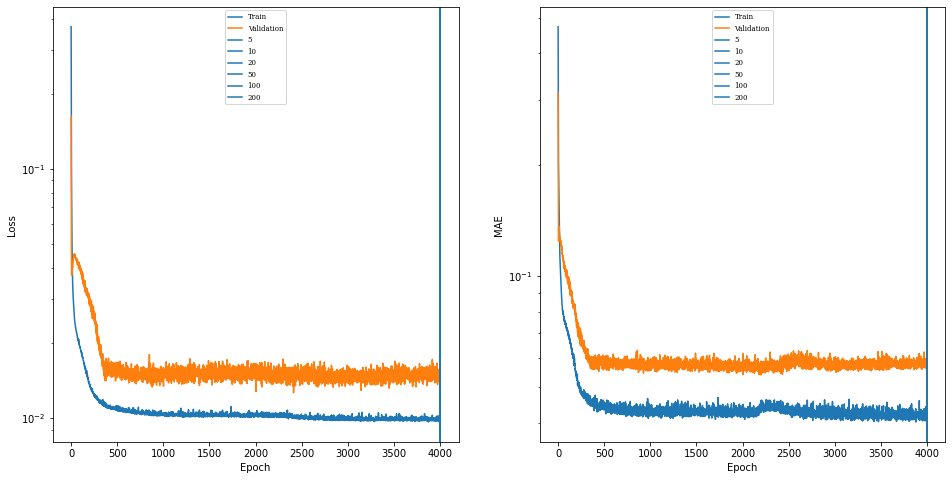

In [ ]:
model = get_model(8,1,0.001)
X_train, X_test, y_train, y_test, qpo_train, qpo_test = split_data(x_vals, y_vals, num_qpos) 
history = model.fit(X_train, y_train, validation_split = 0.1, epochs=4000, batch_size=4, verbose=0)

[ 222.  390.  408. 1186. 1501.  937.]


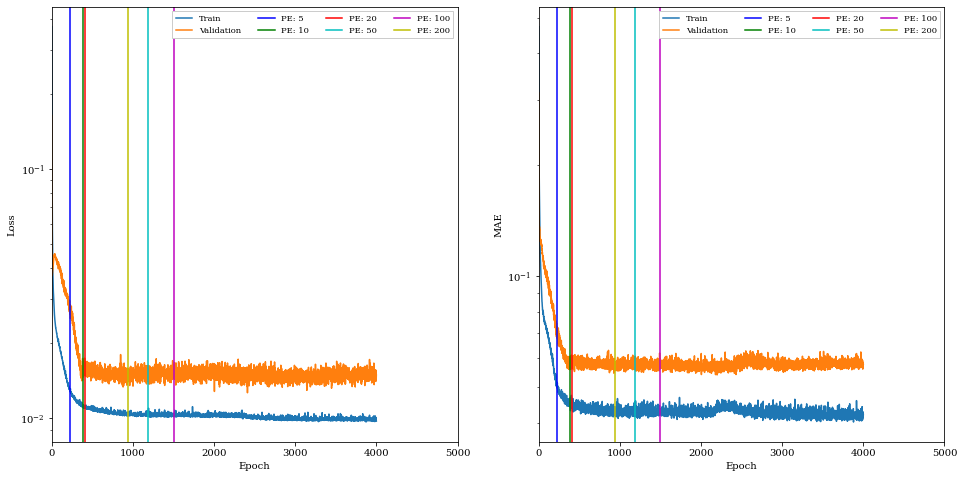

In [ ]:

# PLOT IT
hist = history.history
epochs_arr = np.array(range(1, 4000+1))

train_loss = hist['loss']
val_loss = hist['val_loss']

train_mae = hist['mae']
val_mae = hist['val_mae']

# Make plot

colors = ['b', 'g', 'r', 'c', 'm', 'y']

fig, axs = plt.subplots(1, 2, figsize=(16, 8))
plt.rcParams['font.family']='serif'

axs[0].plot(epochs_arr, train_loss, label='Train')
axs[0].plot(epochs_arr, val_loss, label='Validation')
        
axs[0].set(xlabel='Epoch', ylabel='Loss')

axs[1].plot(epochs_arr, train_mae, label='Train')
axs[1].plot(epochs_arr, val_mae, label='Validation')
axs[1].set(xlabel='Epoch', ylabel='MAE')


print(total_epochs)

for counter, (es, pv) in enumerate(zip(total_epochs, patience_values)):
    for ax in [axs[0], axs[1]]:
        ax.axvline(es, label='PE: '+str(pv), color=colors[counter])

for ax in (axs[0], axs[1]):
    ax.set(yscale='log')
    ax.legend(fontsize='small', ncol=4, framealpha=1, fancybox=False)
    ax.set(xlim=(0, 5000))

plt.show()

## Actual Parameter Search 
* Going to set ```patience``` to ```50```
* use Successive Halving Iterations in hyperparameter tuning?
* Currently using simple hold-out validation, should I use k-fold or iterated k-fold (later is for situations in which one has relatively little data available)  

In [ ]:
for arr_index, sub_arr in enumerate(np.split(permutations, 32)):
    evaluations = np.array([]).reshape(0,6)
    for row in sub_arr: 
        mse, mae = run_earlystop_test(x_vals, y_vals, num_qpos, 5000, int(row[0]), int(row[3]), int(row[2]), row[1]) # fix
        row = np.concatenate(([mse, mae], row)) # fix
        evaluations = np.vstack([evaluations, row])
    
    sub_results_df = pd.DataFrame(evaluations, columns=['mse', 'mae', 'batch_size', 'learning_rate', 'layer_number', 'neuron_number'])
    filename = '/content/gdrive/My Drive/Colab Outputs/Hyperparameter Tuning/'+'sub_arr_results('+str(arr_index)+').csv'
    sub_results_df.to_csv(filename, index=False)
    #files.download(filename)

In [8]:
# test one of the best versions
mse, mae, y_test_flat, y_pred_flat = run_earlystop(x_vals, y_vals, num_qpos, 5000, 32, 4, 2, 0.01)

KeyboardInterrupt: ignored

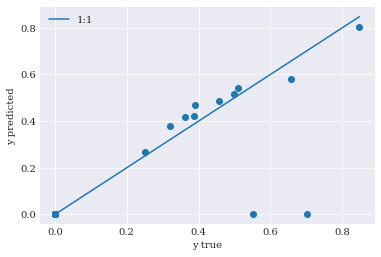

In [ ]:
x_line = np.linspace(min(y_test_flat), max(y_test_flat), 3)

plt.scatter(y_test_flat, y_pred_flat)
plt.plot(x_line, x_line, label='1:1')
plt.xlabel('y true')
plt.ylabel('y predicted')
plt.legend()

plt.show()

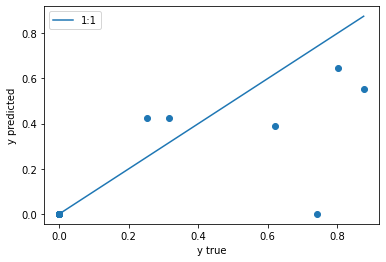

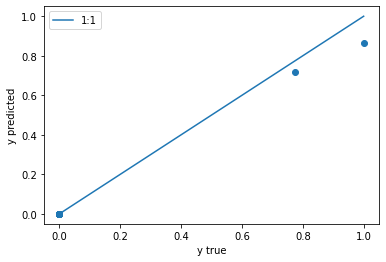

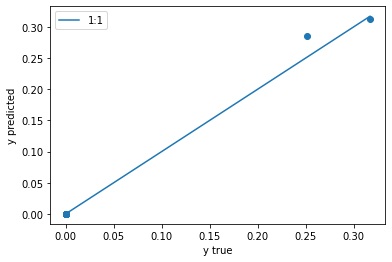

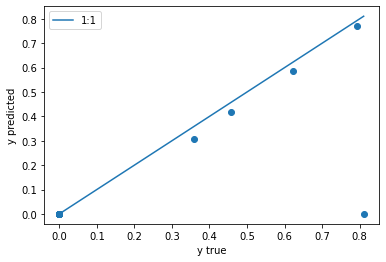

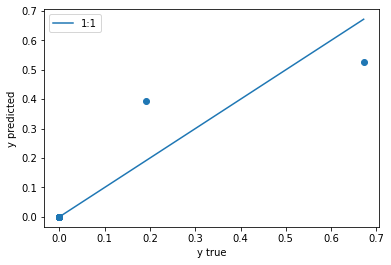

In [17]:
for i in range(5):
    mse, mae, y_test_flat, y_pred_flat, hist = run_earlystop(x_vals, y_vals, num_qpos, 5000, 32, 4, 2, 0.01)
    
    x_line = np.linspace(min(y_test_flat), max(y_test_flat), 3)
    plt.scatter(y_test_flat, y_pred_flat)
    plt.plot(x_line, x_line, label='1:1')
    plt.xlabel('y true')
    plt.ylabel('y predicted')
    plt.legend()

    plt.show()

In [ ]:
while True:pass

## QPO Parameter Correlations


In [11]:
merged_df = pd.read_csv('https://raw.githubusercontent.com/thissop/MAXI-J1535/main/data/processed/fixed_merged.csv')

In [12]:
freqs = np.concatenate((merged_df['first_par1s'], merged_df['second_par1s'], merged_df['third_par1s']))
widths = np.concatenate((merged_df['first_par2s'], merged_df['second_par2s'], merged_df['third_par2s']))
norms = np.concatenate((merged_df['first_norms'], merged_df['second_norms'], merged_df['third_norms']))

df = pd.DataFrame(list(zip(freqs, widths, norms)), columns=['freq', 'width', 'norm'])

df = df.loc[(df!=0).any(axis=1)]

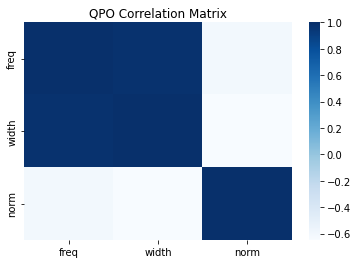

In [13]:
# Correlation matrix plot
sns.heatmap(df.corr(), cmap='Blues')

plt.title('QPO Correlation Matrix')
plt.show()

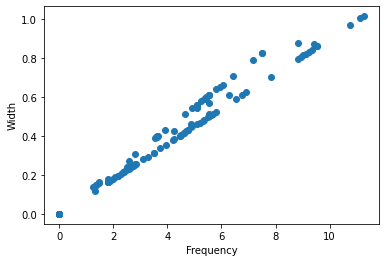

In [14]:
plt.scatter(freqs, widths)
plt.xlabel('Frequency')
plt.ylabel('Width')
plt.show()

## Quick FWHM Test

In [ ]:
combined_df = pd.read_csv('https://raw.githubusercontent.com/thissop/MAXI-J1535/main/data/processed/fixed_merged.csv')

combined_df = combined_df.sample(frac=1) # shuffle the dataframe

def normalize(x):
    x = (x-min(x))/(max(x)-min(x))
    return x

# X

arr_names =  ['hardness', 'tins', 'disk_norm', 'gammas', 'nthcomp_norms', 'intensities']
(hardness, tins, disk_norms, gammas, nthcomp_norms, intensities) = (normalize(np.array(combined_df[arr_name])) for arr_name in arr_names)

## Stack x values
x_vals = np.array([], dtype=np.int64).reshape(0,6) # why are they type int

for a, b, c, d, e, f in zip(hardness, tins, disk_norms, gammas, nthcomp_norms, intensities): 
    new_arr = np.array([float(a), float(b), float(c), float(d), float(e), float(f)])
    x_vals = np.vstack([x_vals, new_arr])

# num QPOS
num_qpos = np.array(combined_df['num_qpos']).reshape(len(combined_df), 1).astype(int)

# Y 
y_vals = np.array([], dtype=np.float32).reshape(0, 3)

width1s, width2s, width3s = (normalize(np.array(combined_df[arr_name])) for arr_name in ['first_par2s', 'second_par2s', 'third_par2s'])

for width1, width2, width3 in zip(width1s, width2s, width3s): 
    new_arr = np.array([float(width1), float(width2), float(width3)])
    y_vals = np.vstack([y_vals, new_arr])

In [ ]:
mse, mae, y_test_flat, y_pred_flat, history = run_earlystop(x_vals, y_vals, num_qpos, 5000, 32, 4, 2, 0.01)

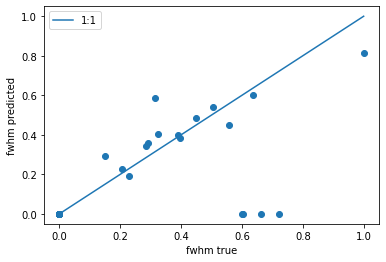

In [ ]:
x_line = np.linspace(min(y_test_flat), max(y_test_flat), 3)

plt.scatter(y_test_flat, y_pred_flat)
plt.plot(x_line, x_line, label='1:1')
plt.xlabel('fwhm true')
plt.ylabel('fwhm predicted')
plt.legend()

plt.show()